PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU (DS105)

---
# BUỔI 03 - PHÁT TRIỂN VÀ ĐÁNH GIÁ MÔ HÌNH
6 - NGUYỄN DIỆU PHƯƠNG (DS105.O11.1)

In [43]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
df = pd.read_csv("data\Model-Evaluation-and-Refinement-R.csv")
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)
df.head()

,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,diesel,gas
0,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,0.890278,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,Medium,0,1
1,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,0.890278,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,Medium,0,1
2,1,122,alfa-romero,std,two,hatchback,rwd,front,94.5,0.822681,0.909722,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,Medium,0,1
3,2,164,audi,std,four,sedan,fwd,front,99.8,0.848630,0.919444,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,Medium,0,1
4,2,164,audi,std,four,sedan,4wd,front,99.4,0.848630,0.922222,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,Medium,0,1


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   normalized-losses  201 non-null    int64  
 2   make               201 non-null    object 
 3   aspiration         201 non-null    object 
 4   num-of-doors       201 non-null    object 
 5   body-style         201 non-null    object 
 6   drive-wheels       201 non-null    object 
 7   engine-location    201 non-null    object 
 8   wheel-base         201 non-null    float64
 9   length             201 non-null    float64
 10  width              201 non-null    float64
 11  height             201 non-null    float64
 12  curb-weight        201 non-null    int64  
 13  engine-type        201 non-null    object 
 14  num-of-cylinders   201 non-null    object 
 15  engine-size        201 non-null    int64  
 16  fuel-system        201 non

## Function

In [47]:
def get_num_columns(database: pd.DataFrame) -> pd.DataFrame:
  _nums = database.select_dtypes(include = 'number').columns.to_list()

  return database[_nums].copy()

In [48]:
def get_obj_columns(database: pd.DataFrame) -> pd.DataFrame:
  _objs = database.select_dtypes(include = 'object').columns.to_list()

  return database[ _objs].copy()

In [49]:
def check_correlation_p_value(column1: pd.Series, column2: pd.Series,
                              coef_threshold = 0.5, p_threshold = 0.05,
                              include = None) -> list:



  includes = [None, 'all']
  assert include in includes, "include just be None or 'all'"

  _coef, _p_value = stats.pearsonr(column1, column2)

  if _p_value > p_threshold:
    return False
  if _coef >= coef_threshold or _coef <= -1.0*coef_threshold:
    if include == 'all':
      return [True, _coef, _p_value]
    return True

  return False

In [50]:
def check_affection(database: pd.DataFrame, target_column: str, coef_threshold = 0.1, p_threshold = 0.05, include = None) -> list:



  includes = [None, 'all']
  assert include in includes, "include just be None or 'all'"

  _affection = []

  for i in database.columns:
    if i == target_column:
      continue
    _affect = check_correlation_p_value(database[i], database[target_column], coef_threshold = coef_threshold, p_threshold = p_threshold, include=include)
    if _affect and include == 'all':
      _affection.append([i, _affect[1], _affect[2]])
    elif _affect:
      _affection.append(i)


  return _affection

In [51]:
def get_strong_week_affection(database: pd.DataFrame, target_column: str, coef_threshold = [0.3, 0.5, 0.8], p_threshold = 0.05) -> dict:
  _strong_affection = []
  _week_affection = []
  _median_affection = []
  database = get_num_columns(database)

  _affection = check_affection(database= database, target_column= target_column, coef_threshold=coef_threshold[0], p_threshold=p_threshold, include = 'all')

  for column in _affection:
    X = {'name': column[0],
         'coef': column[1],
         'p_value': column[2]}
    if X['coef'] <= -1*coef_threshold[2] or  X['coef'] >= 1*coef_threshold[2]:
      _strong_affection.append(X)
    elif X['coef'] >= -1*coef_threshold[1] and X['coef'] <= coef_threshold[1]:
      _week_affection.append(X)
    else:
      _median_affection.append(X)



  return {'strong_affection': _strong_affection,
          'week_affection': _week_affection,
          'median_affection': _median_affection}



In [52]:
def get_category_influence(df:pd.DataFrame, target_column, get_top = None, plimit = 1e-04, ascending =True):
  _df = get_obj_columns(df)
  category = list(_df.columns)
  _category = [re.sub('\W', '', i) for i in category]
  _df.columns = _category
  _df[target_column] = df[target_column]


  model = ols(target_column + ' ~ ' + ' + '.join(_category), data = _df).fit()
  # thực hiện kiểm định ANOVA
  anova_table = sm.stats.anova_lm(model).reset_index()

  category.append('Residual')
  anova_table['index'] = category

  if ascending:
    anova_table = anova_table[anova_table['PR(>F)'] < plimit]
  else:
    anova_table = anova_table[anova_table['PR(>F)'] >= plimit]


  try:
    get_top = int(get_top)

    anova_table = anova_table.sort_values(by = 'PR(>F)', ascending= ascending)[:get_top]

    return anova_table['index'].to_list(), anova_table['PR(>F)'].to_list()
  except:
    anova_table = anova_table.sort_values(by = 'PR(>F)', ascending= ascending)
    return anova_table['index'].to_list(), anova_table['PR(>F)'].to_list()


## Preprocessing

<Axes: >

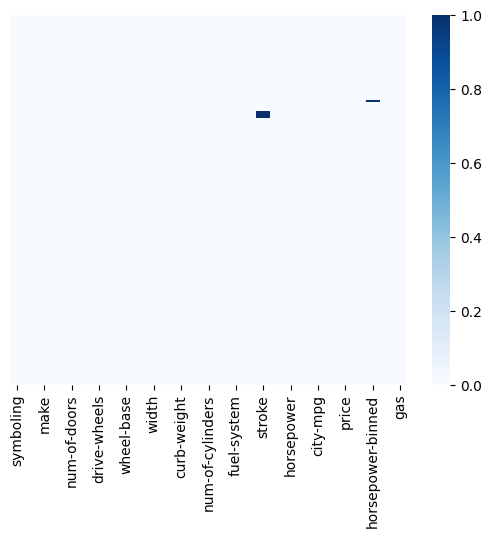

In [53]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = True, cmap="Blues")

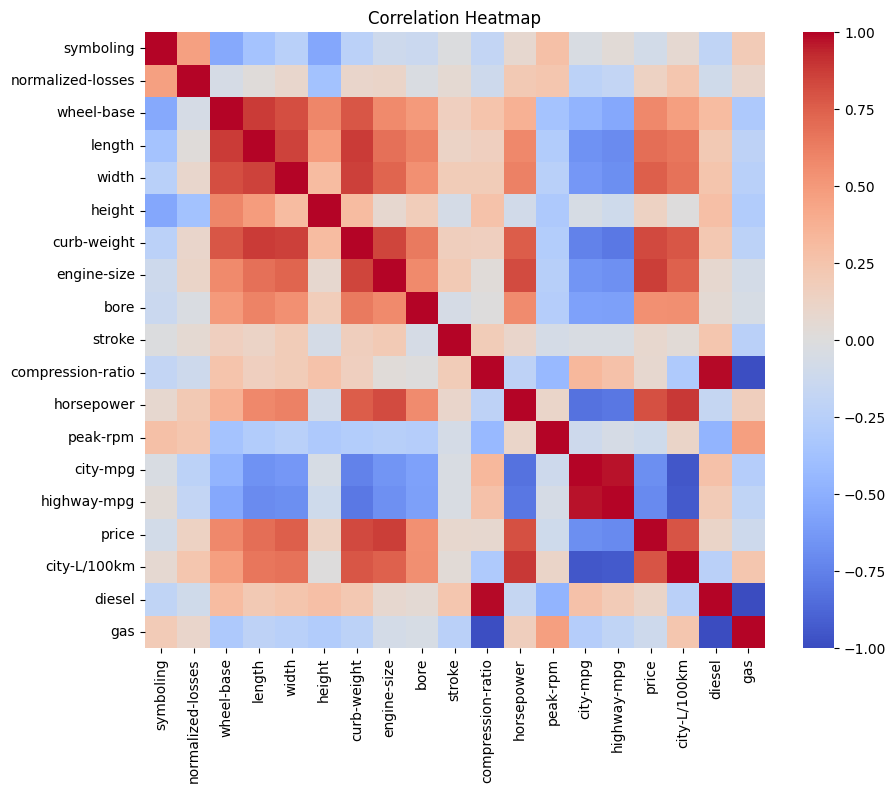

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(get_num_columns(df).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [55]:
df['stroke'].fillna(df['stroke'].mean(), inplace=True)
bin_min = df[df['horsepower-binned'] == 'Low']['horsepower'].max()
bin_max = df[df['horsepower-binned'] == 'High']['horsepower'].min()

def fill_bins(row, column, column_bin, bin_min, bin_max):
    if row[column] < bin_min:
        row[column_bin] = 'Low'
    elif row[column] > bin_max:
        row[column_bin] = 'High'
    else:
        row[column_bin] = 'Medium'

    return row

df = df.apply(lambda row: fill_bins(row, 'horsepower', 'horsepower-binned', bin_min, bin_max), axis=1)

## 1.1 Phân tích thăm dò --> tìm kiếm biến có ảnh hưởng nhất đến giá xe

In [56]:
num_df = get_strong_week_affection(df, 'price')['strong_affection']
num_df

[{'name': 'curb-weight',
  'coef': 0.8344145257702843,
  'p_value': 2.189577238893972e-53},
 {'name': 'engine-size',
  'coef': 0.8723351674455182,
  'p_value': 9.265491622200262e-64},
 {'name': 'horsepower',
  'coef': 0.8095745670036559,
  'p_value': 6.369057428259526e-48}]

In [57]:
num_df = [i['name'] for i in num_df]
num_df

['curb-weight', 'engine-size', 'horsepower']

In [58]:
obj_df = get_category_influence(df, target_column = 'price', plimit = 1e-4)
obj_df

(['make',
  'drive-wheels',
  'engine-type',
  'num-of-cylinders',
  'horsepower-binned',
  'aspiration',
  'engine-location'],
 [3.5755731167566997e-78,
  6.5598732977812e-17,
  2.379072560098517e-14,
  7.119062932602393e-11,
  7.85796362055695e-09,
  2.2322778853004794e-06,
  2.286752698991522e-05])

In [59]:
obj_df = obj_df[0]
obj_df

['make',
 'drive-wheels',
 'engine-type',
 'num-of-cylinders',
 'horsepower-binned',
 'aspiration',
 'engine-location']

## 2.1. Mô hình hồi quy tuyến tính đơn biến

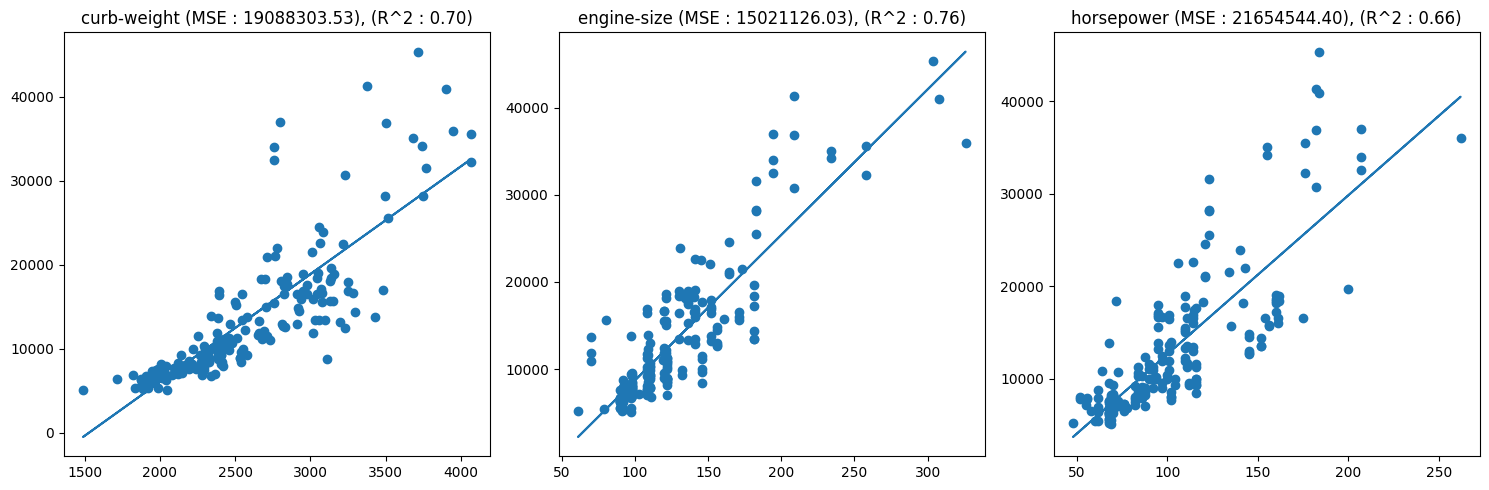

In [60]:


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for j in range(3):
    idx = j
    if (idx >= len(df[num_df].columns)):
        break

    model = LinearRegression()
    input = df[num_df[idx]]
    input = np.reshape(input.values, (-1, 1))
    output = df['price']
    model.fit(input, output)

    prediction = model.predict(input)
    mse = mean_squared_error(output, prediction)
    r2 = r2_score(output, prediction)

    axes[j].plot(input, prediction)
    axes[j].scatter(input, output)
    axes[j].set_title(f'{num_df[idx]} (MSE : {mse:.2f}), (R^2 : {r2:.2f})')

    plt.tight_layout()

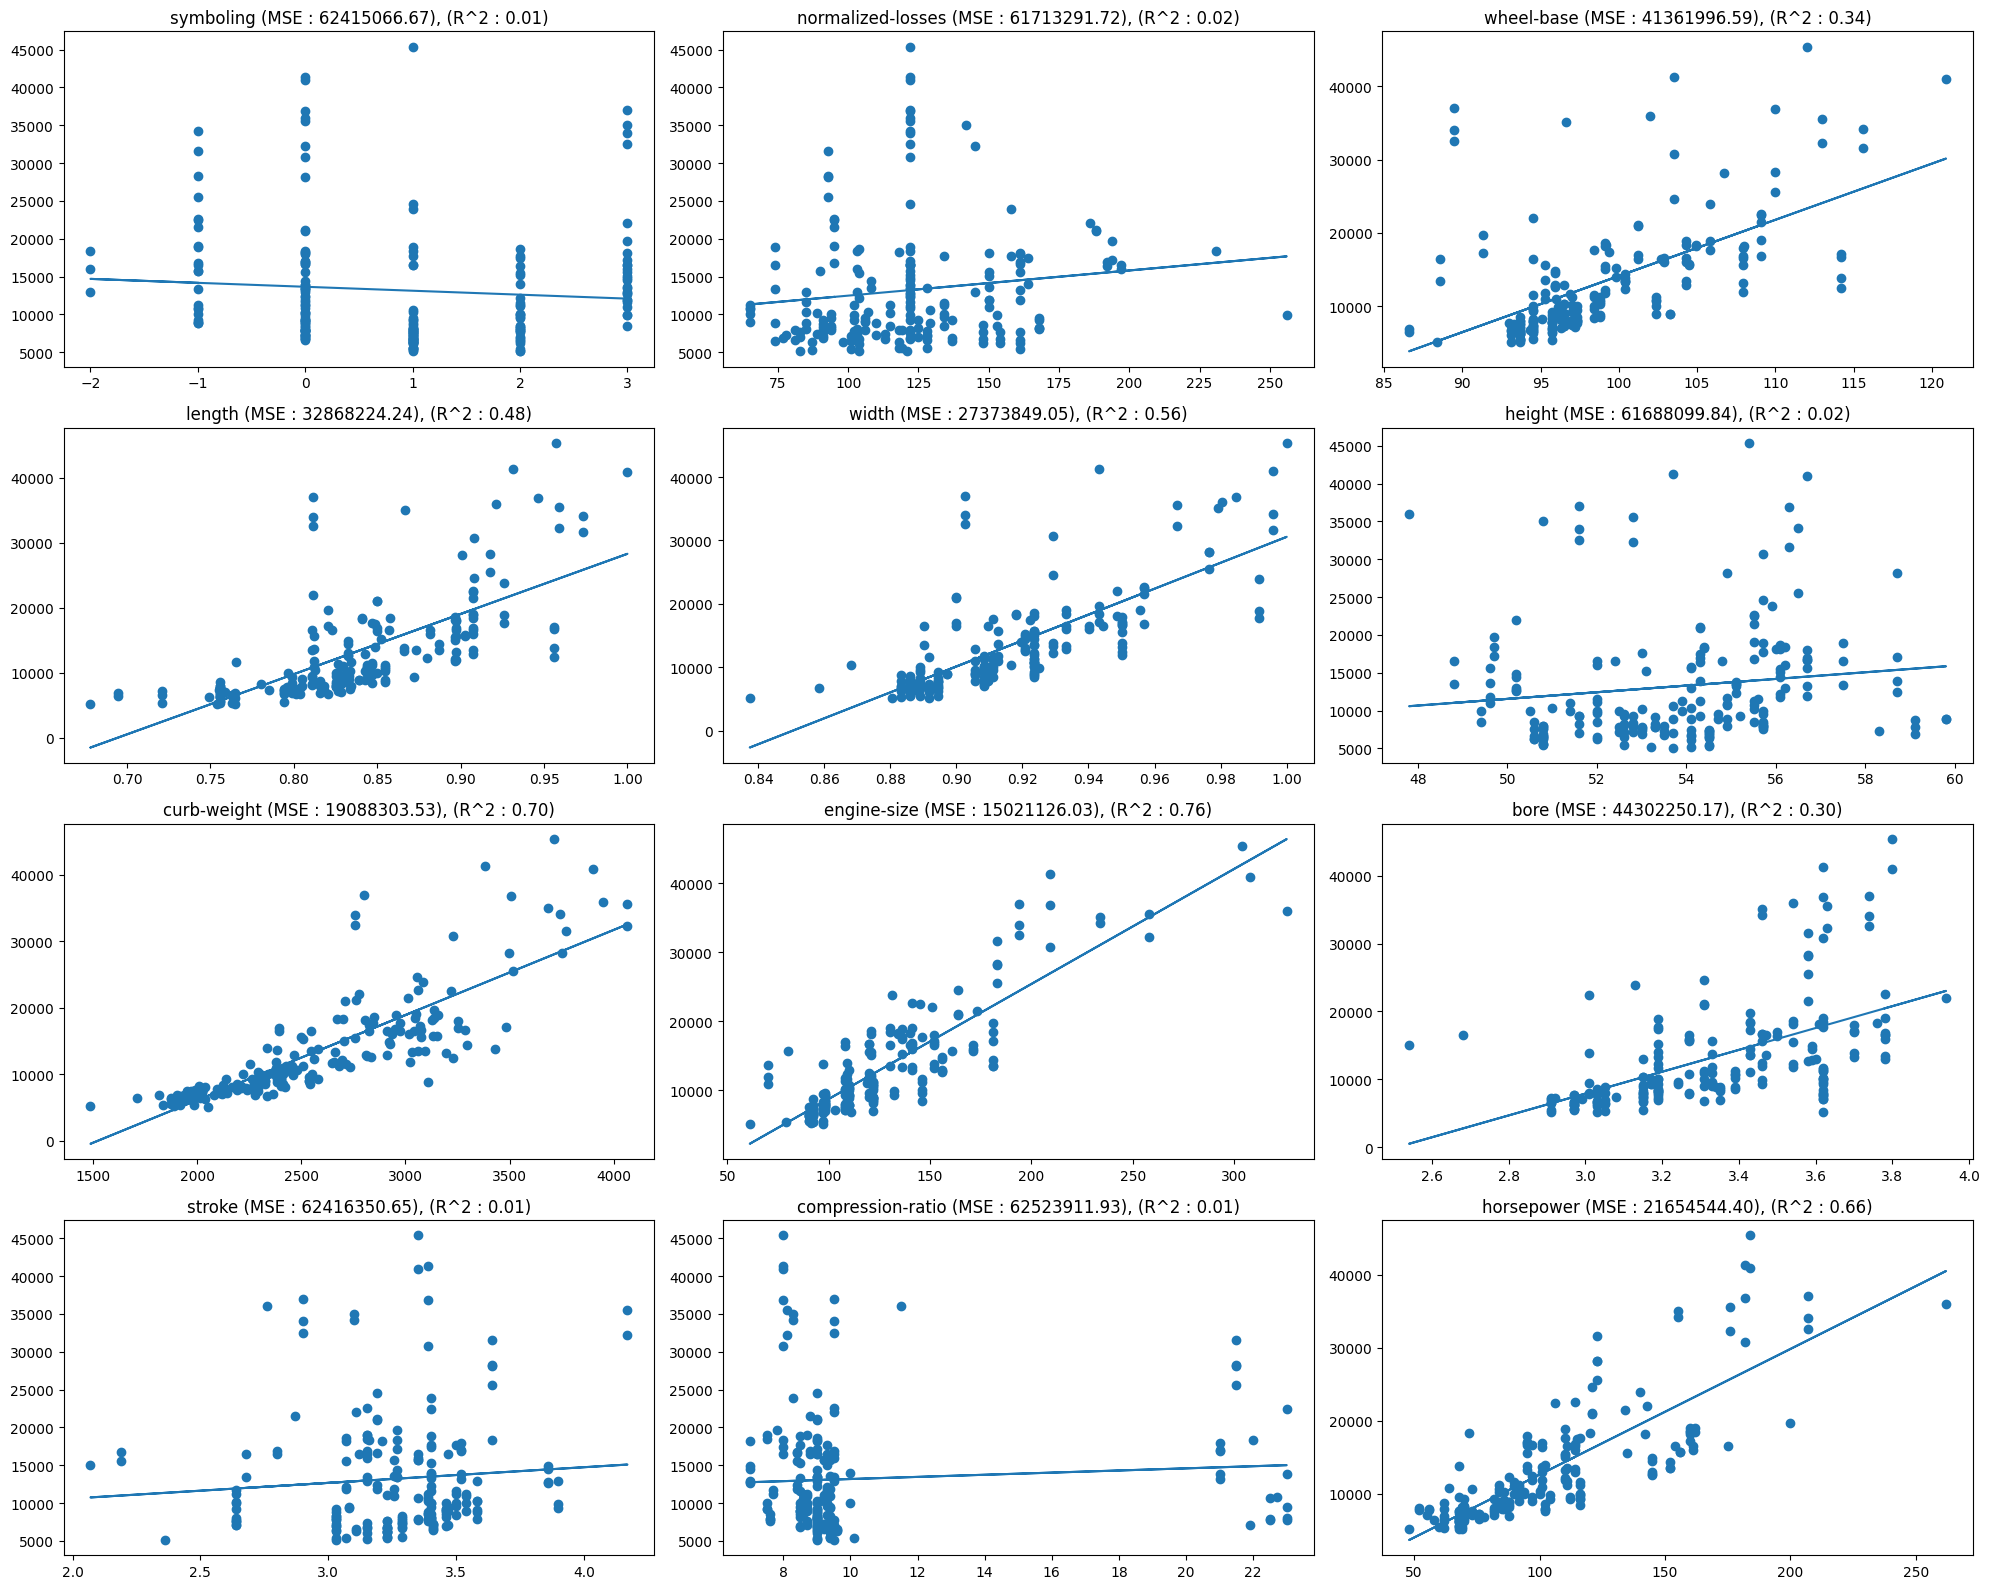

In [61]:
_df_num = get_num_columns(df).columns

fig, axes = plt.subplots(4, 3, figsize=(20, 16))
for i in range(4):
    for j in range(3):
        idx = i * 3 + j
        if (idx >= len(df[_df_num].columns)):
            break

        model = LinearRegression()
        input = df[_df_num[idx]]
        input = np.reshape(input.values, (-1, 1))
        output = df['price']
        model.fit(input, output)

        prediction = model.predict(input)
        mse = mean_squared_error(output, prediction)
        r2 = r2_score(output, prediction)

        axes[i][j].plot(input, prediction)
        axes[i][j].scatter(input, output)
        axes[i][j].set_title(f'{_df_num[idx]} (MSE : {mse:.2f}), (R^2 : {r2:.2f})')

        plt.tight_layout()

## 2.2. Mô hình hồi quy tuyến tính đa biến

In [62]:
model = LinearRegression()

input = df[_df_num]
output = df['price']

model.fit(input, output)

LinearRegression()

In [63]:
prediction = model.predict(input)
mse = mean_squared_error(output, prediction)
r2 = r2_score(output, prediction)

mse, r2

(2.233799186536236e-23, 1.0)

## 3.1. Mô hình hồi quy đa thức đơn biến

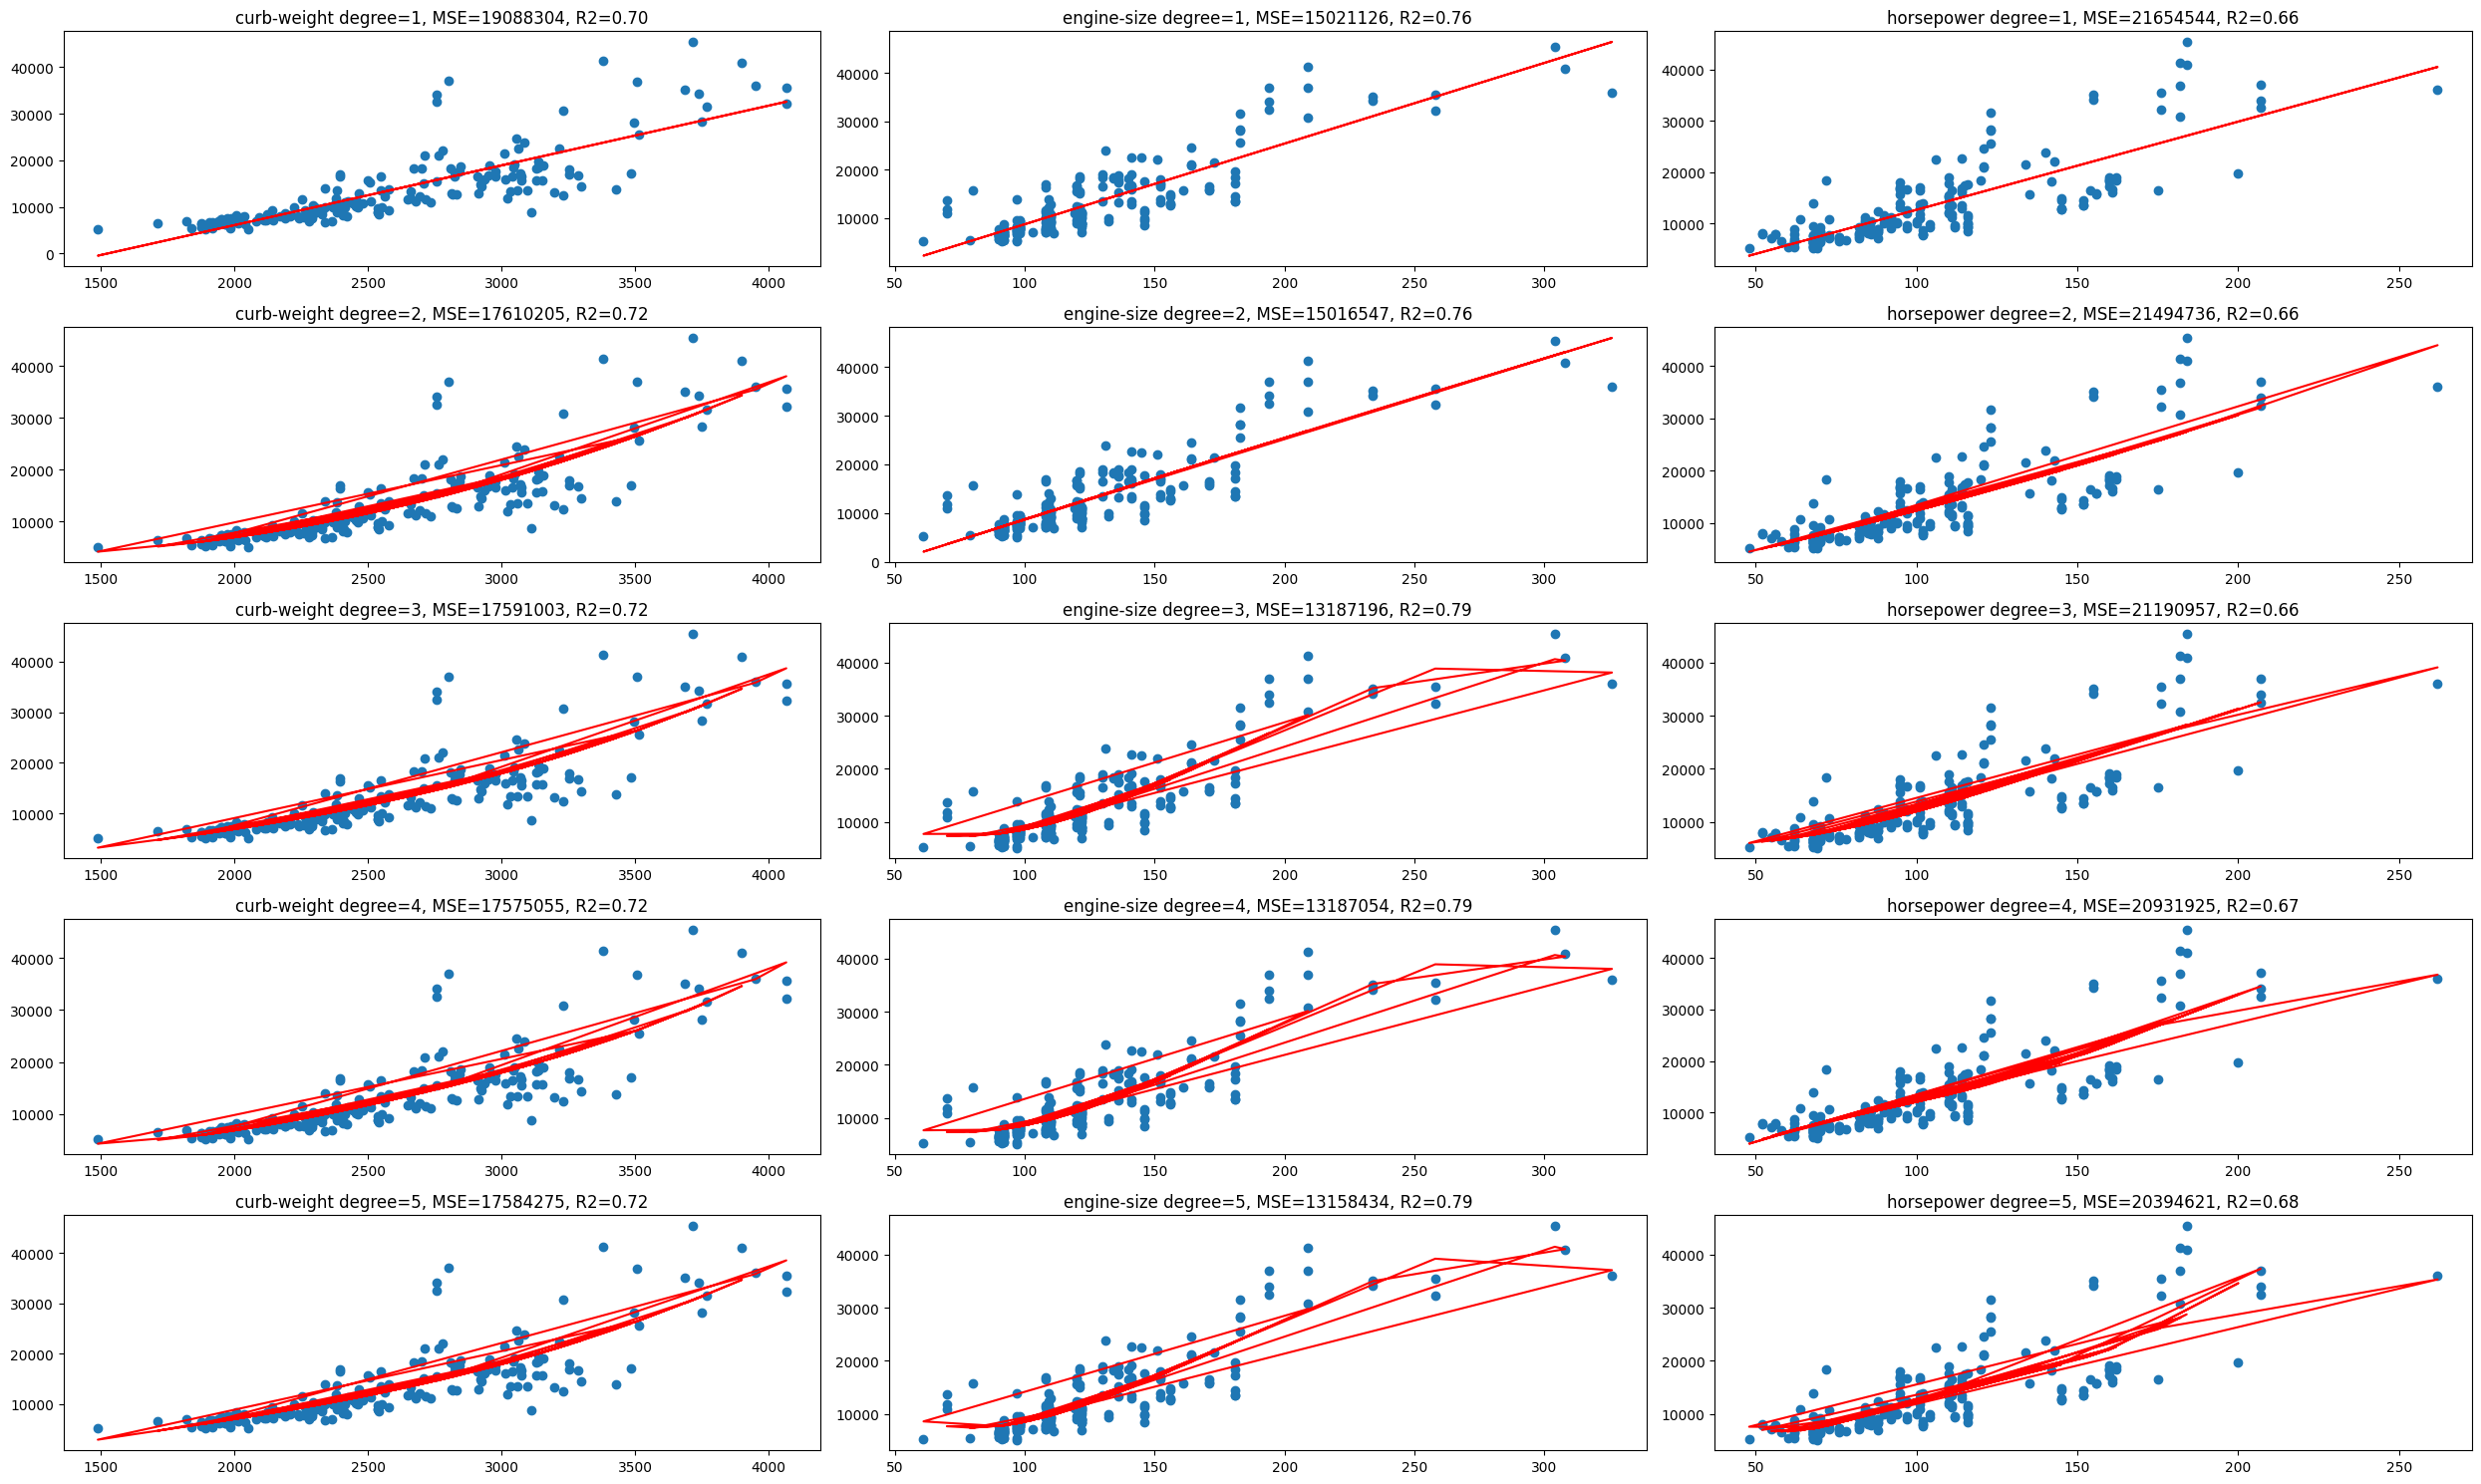

In [64]:
fig, axes = plt.subplots(5, 3, figsize=(25, 15))

for i in range(5):
    for j in range(3):
        idx = i * 5 + j

        pipeline = Pipeline([
            ('polynomial', PolynomialFeatures(degree = i+1)),
            ('model', LinearRegression())
        ])

        input = df[num_df[j]]
        input = np.reshape(input.values, (-1, 1))
        output = df['price']
        pipeline.fit(input, output)

        prediction = pipeline.predict(input)
        mse = mean_squared_error(output, prediction)
        r2 = r2_score(output, prediction)

        axes[i][j].plot(input, prediction, color = 'red')
        axes[i][j].scatter(input, output)
        axes[i][j].set_title(f'{num_df[j]} degree={i+1}, MSE={mse:.0f}, R2={r2:.2f}')

        plt.tight_layout()

## 4.1. Mô hình hồi quy đa thức đa biến

In [65]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])

input = df[num_df]
output = df['price']

pipeline.fit(input, output)

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures()),
                ('model', LinearRegression())])

In [66]:
multi_polinomial = []

for i in range(4):
    for j in range(3):
        idx = i * 3 + j
        if (idx >= len(num_df)):
            break

        pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('polynomial', PolynomialFeatures(degree=idx+1)),
            ('model', LinearRegression())
        ])

        input = df[num_df]
        output = df['price']

        pipeline.fit(input, output)

        prediction = pipeline.predict(input)
        mse = mean_squared_error(output, prediction)
        r2 = r2_score(output, prediction)

        value = {
            'Degree' : idx+1,
            'MSE' : mse,
            'R^2' : r2
        }

        multi_polinomial.append(value)

multi_polinomial

[{'Degree': 1, 'MSE': 11994814.244502733, 'R^2': 0.8091263794284136},
 {'Degree': 2, 'MSE': 10085920.965354873, 'R^2': 0.8395026206980694},
 {'Degree': 3, 'MSE': 7233959.768191681, 'R^2': 0.8848859128721602}]

## 5.1 Xây dựng mô hình hồi quy tuyến tính dự đoán price

In [68]:
from sklearn.preprocessing import LabelEncoder


for each in obj_df:
  label = LabelEncoder()
  encode = label.fit_transform(df[each])
  df[each] = encode

df[obj_df].head()

,make,drive-wheels,engine-type,num-of-cylinders,horsepower-binned,aspiration,engine-location
0,0,2,0,2,2,0,0
1,0,2,0,2,2,0,0
2,0,2,4,3,2,0,0
3,1,1,2,2,2,0,0
4,1,0,2,1,2,0,0


In [70]:
scale = StandardScaler()
df[num_df] = scale.fit_transform(df[num_df])
df[num_df].head()

,curb-weight,engine-size,horsepower
0,-0.014858,0.075389,0.203754
1,-0.014858,0.075389,0.203754
2,0.518080,0.606234,1.357416
3,-0.423766,-0.431327,-0.037710
4,0.520017,0.220165,0.311072


In [72]:
X = df[num_df + obj_df].values
y = df['price'].values

In [73]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('town', OneHotEncoder(), [0, 1, 2])], remainder = 'passthrough')
X = ct.fit_transform(X)

In [74]:
model = LinearRegression()

model.fit(X, y)

LinearRegression()

In [75]:
model.score(X, y)

0.9986946691598022